In [34]:
from itertools import groupby
from operator import itemgetter
import os

import pandas as pd
import pickle
from sklearn.decomposition import PCA
import sparse

import sktensor
#from tensorly import decomposition
from cp_orth import orth_als

import logging
logging.basicConfig(
    format="%(asctime)s %(module)s (%(lineno)s) %(levelname)s %(message)s",
    level=logging.DEBUG)

from matplotlib import pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

Populating the interactive namespace from numpy and matplotlib


/home/makrai/tool/python/venv3/lib/python3.4/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rank']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
names = ['verb', 'args', 'mazsola1', 'mazsola_.5m', 'tade', 'prev', 'prev_inf', 'MetaMorpho', 
         'sum_rel_freq']
manocska = pd.read_csv('/home/makrai/repo/manocska/manocska.sorted.txt', sep='\t', names=names, index_col=[0,1], 
                       na_values='None')

1. verb lemma (the verbal particle is separated by pipe, |)
2. arguments, separated by space
3. frequency based on the Hungarian verbal structures (dictionary)
4. frequency based on the 500000 verbal structures (list)
5. frequency based on Tádé
6. frequency based on Ágnes Kalivoda's MA thesis (in the case no particle, this field in None)
7. frequency based on Ágnes Kalivoda's collection _Infinitival constructions in Hungarian_; 
    in case of no infinitival argument, this field is None
8. frequency based on MetaMorpho
9. sum of the relative frequencies of the freame in each resource

In [13]:
manocska = manocska.fillna(0)

In [14]:
manocska.head()

,,mazsola1,mazsola_.5m,tade,prev,prev_inf,MetaMorpho,sum_rel_freq
verb,args,,,,,,,
kell,INF,0,0,365197,0.0,1512519.0,0,0.219617
tud,INF,0,0,85760,0.0,1388057.0,0,0.173420
lehet,INF,0,0,110822,0.0,1139548.0,0,0.146930
fog,INF,0,0,47494,0.0,840888.0,0,0.104555
akar,INF,0,0,27731,0.0,612623.0,0,0.075398


# A preverb--verb--case tensor

In [15]:
prevs, verbs = zip(*[verb.split('|') for verb, frame in manocska.index if '|' in verb])
cases = [case for verb, frame in manocska.index for case in frame.split(' ')]

In [16]:
def marginal(prevs):
    ans = sorted([(key, len(list(group))) for key, group in groupby(sorted(prevs))], 
                  key=itemgetter(1), reverse=True)
    print(ans[:6])
    return dict(ans), {w: i for (i, (w, freq)) in enumerate(ans)}

In [17]:
freqs, dicts = zip(*[marginal(list_) for list_ in [prevs, verbs, cases]])

[('meg', 91070), ('el', 60531), ('ki', 48548), ('be', 32611), ('fel', 31793), ('le', 21611)]
[('ad', 6561), ('vesz', 5041), ('tesz', 4734), ('mond', 3917), ('megy', 3717), ('ír', 3672)]
[('[Acc]', 362663), ('[Ine]', 140067), ('[Ins]', 97720), ('[Supe]', 96529), ('[Dat]', 96330), ('[Subl]', 94479)]


In [20]:
def get_tensor(resource='mazsola1', middle_end='sktensor', add_smooth=1):
    coords, data = [[], [], []], []
    for i, ((verb, frame), row) in enumerate(manocska.iterrows()):
        if not i % 100000:
            logging.info('{} {} {}'.format(i, verb, frame))
        try:
            prev, verb = verb.split('|')
        except:
            continue
        val = np.log(row[resource] + add_smooth)
        for case in frame.split(' '):
            marg_prev_verb = np.log(freqs[0][prev]) + np.log(freqs[1][verb])
            for i, item in enumerate([prev, verb, case]):
                coords[i].append(dicts[i][item])
                if add_smooth:
                    val -= marg_prev_verb + np.log(freqs[2][case])
            data.append(val)
    shape = tuple(map(len, freqs))
    logging.debug(([len(mode) for mode in coords], len(data)))
    if middle_end == 'tensorly':
        tensor = sparse.COO(coords, data, shape=shape)#, has_duplicates=False)
    elif middle_end == 'sktensor':
        tensor = sktensor.sptensor(tuple(coords), data, shape=shape)
    logging.info(tensor)
    return tensor

In [21]:
tensor = get_tensor()

2018-10-09 15:34:09,510 <ipython-input-20-a46141067ffd> (5) INFO 0 kell INF
2018-10-09 15:34:13,537 <ipython-input-20-a46141067ffd> (5) INFO 100000 fenn|áll =alapján [Temp]
2018-10-09 15:34:17,525 <ipython-input-20-a46141067ffd> (5) INFO 200000 el|terel [Supe] forgalom[Acc]
2018-10-09 15:34:20,849 <ipython-input-20-a46141067ffd> (5) INFO 300000 el|hangzik =előtt [Supe]
2018-10-09 15:34:23,791 <ipython-input-20-a46141067ffd> (5) INFO 400000 el|tör váll[Poss][Nom]
2018-10-09 15:34:25,250 <ipython-input-20-a46141067ffd> (5) INFO 500000 rúg százalékár[Poss][Nom]
2018-10-09 15:34:26,522 <ipython-input-20-a46141067ffd> (5) INFO 600000 kifogásol [Acc] [Ill]
2018-10-09 15:34:27,727 <ipython-input-20-a46141067ffd> (5) INFO 700000 követ árnyék[Poss][Nom]
2018-10-09 15:34:28,910 <ipython-input-20-a46141067ffd> (5) INFO 800000 keres =óta [Acc] [Dat]
2018-10-09 15:34:30,198 <ipython-input-20-a46141067ffd> (5) INFO 900000 lehet =felé [All]
2018-10-09 15:34:31,071 <ipython-input-20-a46141067ffd> (19)

In [22]:
rank = 3

In [38]:
filen = '/mnt/permanent/home/makrai/project/prev/prev-verb-cas-ktensor.pkl'
if os.path.exists(filen):
    ktensor = pickle.load(open(filen, mode='rb'))
else:
    ktensor, fit, itr, exectimes = orth_als(tensor, rank)
    pickle.dump(ktensor, open(filen, mode='wb'))

In [28]:
ktensor.lmbda

array([ 6471.51409875, 16173.02368539,    71.79852599])

In [29]:
def scatter_sorted(ktensor, mode=0):
    order = np.argsort(-ktensor.lmbda)
    plt.scatter(ktensor.U[mode][:,order[0]], ktensor.U[mode][:,order[1]], c=ktensor.U[mode][:,order[2]])

1


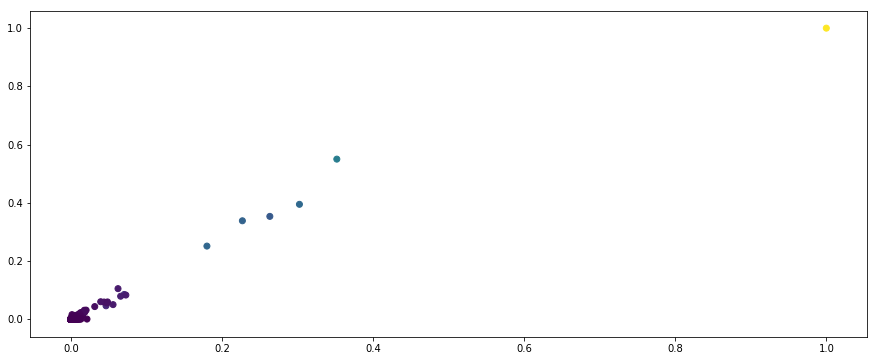

In [33]:
scatter_sorted(ktensor, mode=2)